# Kanban Metrics

This is an experiment of using Jira issue changelogs to compute a historical record of a Kanban, then using that historical record to run a Kaplan-Meier estimate and a Monte Carlo simulation to gauge:

1. how likely will a single issue be completed in N days
2. how much work a team can take on over the next N days
3. and by what date N number of work items could be completed


---

## Data Prep

First, let's read in some Jira changelog data. 

We have two options:

1. From a Looker export: [data.csv](data.csv). This data file was generated with a query stored in [log.sql](log.sql) run against a Redshift connection in Looker.
2. From a Jira export: [data2.csv](data2.csv). This data file was generated directly from the Jira REST API.

In [1]:
import collections

import lifelines
import matplotlib
import matplotlib.pyplot
import pandas
import seaborn

import util
util.prep_libs()

In [2]:
data = pandas.read_csv(
    'data2.csv', parse_dates=['status_change_date', 'issue_created_date'])

# let's check to make sure the data is loaded
data = data.sort_values(['issue_id', 'status_change_date'])

data.head()

,project_id,project_key,issue_id,issue_key,issue_type_id,issue_type_name,issue_title,issue_created_date,changelog_id,status_from_id,status_from_name,status_to_id,status_to_name,status_from_category_name,status_to_category_name,status_change_date
0,10062,CO,46071,CO-577,10004,Bug,Team member cannot see Task History items for ...,2020-01-02 13:26:27.309000-08:00,278839.0,10000.0,To Do,10115.0,Prioritized,To Do,To Do,2020-01-03 03:57:37.081000-08:00
1,10062,CO,46071,CO-577,10004,Bug,Team member cannot see Task History items for ...,2020-01-02 13:26:27.309000-08:00,278868.0,10115.0,Prioritized,10016.0,Deployed,To Do,Done,2020-01-03 06:33:21.087000-08:00
2,10062,CO,46081,CO-578,10002,Task,Allow members to create and modify their own t...,2020-01-03 03:21:35.587000-08:00,278815.0,10000.0,To Do,10115.0,Prioritized,To Do,To Do,2020-01-03 03:21:50.178000-08:00
3,10062,CO,46081,CO-578,10002,Task,Allow members to create and modify their own t...,2020-01-03 03:21:35.587000-08:00,278861.0,10115.0,Prioritized,3.0,In Progress,To Do,In Progress,2020-01-03 06:27:14.111000-08:00
4,10062,CO,46081,CO-578,10002,Task,Allow members to create and modify their own t...,2020-01-03 03:21:35.587000-08:00,279286.0,3.0,In Progress,10017.0,Review,In Progress,In Progress,2020-01-06 02:52:43.500000-08:00


Now that we have the data, let's coallesce the changelogs into individual issues changelogs for easy lookup.

In [3]:
issues = collections.defaultdict(list)
issue_ids = dict()
issue_keys = dict()
issue_types = dict()
for row, item in data.iterrows():
    issues[item.issue_id].append(item)
    issue_types[item.issue_id] = item.issue_type_name
    issue_ids[item.issue_key] = item.issue_id
    issue_keys[item.issue_id] = item.issue_key

In [4]:
collections.Counter(issue_types.values())

Counter({'Bug': 181, 'Task': 196, 'Story': 271, 'Epic': 21, 'Sub-task': 54})

What we want to be able to do at this point is to know the total time an issue spends in the "In Progress" state. We could take a look at all of the state changes and compute the sum of the time residing in the "In Progess" state. An alternative that is easier to compute (with less accuracy) is to track when the issue was first created, when it first moved into work in progress, and when it finally completed, ignoring other state transitions in between.

In [5]:
issue_statuses = collections.defaultdict(dict)
for issue_id, issue in issues.items():
    for update in issue:
        # learn when the issue was first created
        if not issue_statuses[issue_id].get('first_created'):
            issue_statuses[issue_id]['first_created'] = update.issue_created_date
        issue_statuses[issue_id]['first_created'] = min(issue_statuses[issue_id]['first_created'], update.issue_created_date)

        # learn when the issue was first moved to in progress
        if update.status_to_category_name == 'In Progress':
            if not issue_statuses[issue_id].get('first_in_progress'):
                issue_statuses[issue_id]['first_in_progress'] = update.status_change_date
            issue_statuses[issue_id]['first_in_progress'] = min(issue_statuses[issue_id]['first_in_progress'], update.status_change_date)
        
        # learn when the issue was finally moved to completion
        if update.status_to_category_name == 'Complete' or update.status_to_category_name == 'Done':
            if not issue_statuses[issue_id].get('last_complete'):
                issue_statuses[issue_id]['last_complete'] = update.status_change_date
            issue_statuses[issue_id]['last_complete'] = max(issue_statuses[issue_id]['last_complete'], update.status_change_date)

Finally, we create a new data set of each issue with the dates when the state changes happened. We also compute the lead and cycle times of each issue.

In [6]:
issue_data = pandas.DataFrame(columns=['issue_key', 'issue_type', 'new', 'new_day', 'in_progress', 'in_progress_day', 'complete', 'complete_day', 'lead_time', 'lead_time_days', 'cycle_time', 'cycle_time_days'])

for issue_id in issue_statuses:
    new = issue_statuses[issue_id].get('first_created')
    in_progress = issue_statuses[issue_id].get('first_in_progress')
    complete = issue_statuses[issue_id].get('last_complete')
    
    if complete:
        lead_time = complete - new
        
        if in_progress:
            cycle_time = complete - in_progress
        else:
            cycle_time = pandas.Timedelta(days=0)
    else:
        lead_time = pandas.Timedelta(days=0)
        cycle_time = pandas.Timedelta(days=0)
    
    issue_data = issue_data.append({
        'issue_key': issue_keys[issue_id],
        'issue_type': issue_types[issue_id],
        'new': new,
        'new_day': None,
        'in_progress': in_progress,
        'in_progress_day': None,
        'complete': complete,
        'complete_day': None,
        'lead_time': lead_time,
        'lead_time_days': None,
        'cycle_time': cycle_time,
        'cycle_time_days': None,
    }, ignore_index=True)

# truncate days to omit time
issue_data['new_day'] = issue_data['new'].values.astype('<M8[D]')
issue_data['in_progress_day'] = issue_data['in_progress'].values.astype('<M8[D]')
issue_data['complete_day'] = issue_data['complete'].values.astype('<M8[D]')

# add column for lead time represented as days
issue_data['lead_time_days'] = issue_data['lead_time'] / pandas.to_timedelta(1, unit='D')
# round lead time less than 1 hour to zero
issue_data.loc[issue_data['lead_time_days'] < 1/24.0, 'lead_time_days'] = 0

# add column for cycle time represented as days
issue_data['cycle_time_days'] = issue_data['cycle_time'] / pandas.to_timedelta(1, unit='D')
# round cycle time less than 1 hour to zero
issue_data.loc[issue_data['cycle_time_days'] < 1/24.0, 'cycle_time_days'] = 0

issue_data.head(5)

/Users/jordan/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/Users/jordan/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/Users/jordan/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


,issue_key,issue_type,new,new_day,in_progress,in_progress_day,complete,complete_day,lead_time,lead_time_days,cycle_time,cycle_time_days
0,CO-577,Bug,2020-01-02 13:26:27.309000-08:00,2020-01-02,None,NaT,2020-01-03 06:33:21.087000-08:00,2020-01-03,0 days 17:06:53.778000,0.713122,0 days 00:00:00,0.000000
1,CO-578,Task,2020-01-03 03:21:35.587000-08:00,2020-01-03,2020-01-03 06:27:14.111000-08:00,2020-01-03,2020-01-06 07:49:29.985000-08:00,2020-01-06,3 days 04:27:54.398000,3.186046,3 days 01:22:15.874000,3.057128
2,CO-579,Bug,2020-01-03 04:39:12.038000-08:00,2020-01-03,2020-01-06 06:30:40.361000-08:00,2020-01-06,2020-01-06 09:13:25.135000-08:00,2020-01-06,3 days 04:34:13.097000,3.190429,0 days 02:42:44.774000,0.113018
3,CO-580,Bug,2020-01-07 01:46:58.637000-08:00,2020-01-07,2020-01-07 07:14:36.631000-08:00,2020-01-07,2020-01-07 07:45:42.823000-08:00,2020-01-07,0 days 05:58:44.186000,0.249123,0 days 00:31:06.192000,0.000000
4,CO-581,Task,2020-01-07 03:12:45.168000-08:00,2020-01-07,2020-01-14 04:32:16.688000-08:00,2020-01-14,2020-01-15 03:16:56.814000-08:00,2020-01-15,8 days 00:04:11.646000,8.002913,0 days 22:44:40.126000,0.947687



---


## Metrics

Let's take a brief look at some basic Kanban metrics, like Cycle Time & Throughput.

### Cycle Time

Cycle Time is the amount of time an issue spends "In Progress".

In other words, it's the total duration from the moment an issue is started until it is is finished.

In [7]:
FILTER_ISSUES_SINCE = '2020-01-01'

cycle_data = issue_data.copy()
cycle_data = cycle_data.where(cycle_data['complete_day'] > pandas.to_datetime(FILTER_ISSUES_SINCE)).dropna()

# drop issues with a cycle time less than 1 hour
cycle_data = cycle_data.where(issue_data['cycle_time_days'] > (1/24.0)).dropna()

cycle_data['cycle_time_days_ma'] = cycle_data['cycle_time_days'].rolling(window=20).mean().dropna()
cycle_data['cycle_time_days_avg'] = cycle_data['cycle_time_days'].mean()

/Users/jordan/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


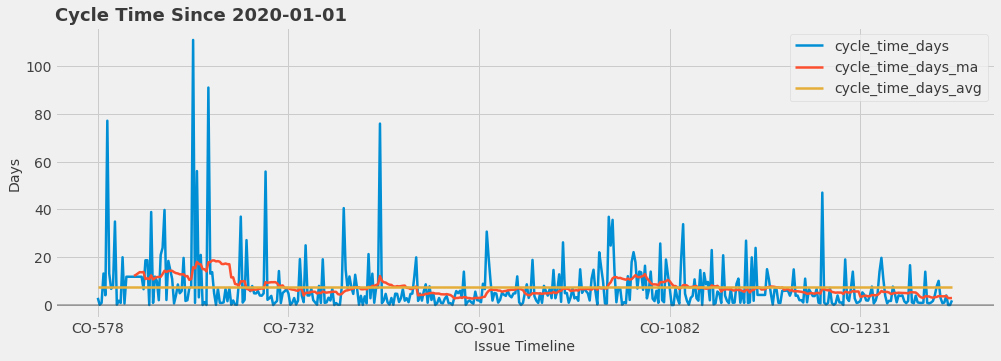

In [8]:
ax = cycle_data.plot(
    x='issue_key', y=['cycle_time_days', 'cycle_time_days_ma', 'cycle_time_days_avg'], linewidth=2.5, figsize=(15, 5), legend=True)

ax.set_title("Cycle Time Since {}".format(FILTER_ISSUES_SINCE), loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'semibold'})

ax.set_xlabel('Issue Timeline')
ax.set_ylabel('Days')

#ax.set_xticks([cycle_data['issue_key'][i] for i in range(0, len(cycle_data), len(cycle_data)//10)])
#ax.set_xticklabels([cycle_data['complete_day'][i] for i in range(0, len(cycle_data), len(cycle_data)//10)], rotation=45)

ax.axhline(y=0, color=util.lightgrey, alpha=.5);

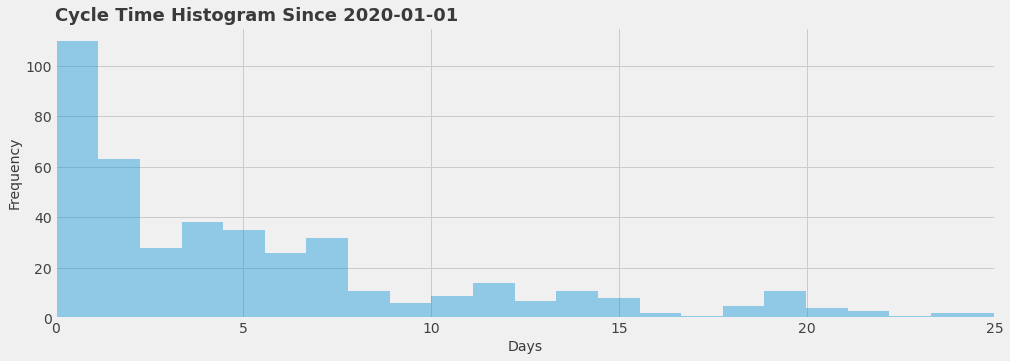

In [9]:
matplotlib.pyplot.figure(figsize=(15,5))

ax = seaborn.distplot(cycle_data['cycle_time_days'], bins=100, kde=False)
ax.set_title("Cycle Time Histogram Since {}".format(FILTER_ISSUES_SINCE), loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'semibold'})
ax.set_ylabel('Frequency')
ax.set_xlabel('Days')
_ = ax.set_xlim([0, 25])

### Throughput

Throughput is the number of issues completed in a given week.

In [10]:
FILTER_ISSUES_SINCE = '2020-01-01'

throughput_data = issue_data.copy()
throughput_data = throughput_data.where(throughput_data['complete_day'] > pandas.to_datetime(FILTER_ISSUES_SINCE)).dropna()

throughput = pandas.crosstab(throughput_data.complete_day, issue_data.issue_type, colnames=[None]).reset_index()

# throughput is the sum of all issue types completed during a time frame
throughput['Throughput'] = throughput.Epic + throughput.Bug + throughput.Story + throughput.Task + throughput['Sub-task']

date_range = pandas.date_range(
    start=throughput.complete_day.min(),
    end=throughput.complete_day.max()
)

throughput = throughput.set_index('complete_day').reindex(date_range).fillna(0).astype(int).rename_axis('Date')

In [11]:
throughput_per_week = pandas.DataFrame(
    throughput['Throughput'].resample('W-Mon').sum()
).reset_index()

throughput_per_week['Moving Average'] = throughput_per_week['Throughput'].rolling(window=4).mean().dropna()
throughput_per_week['Average'] = throughput_per_week['Throughput'].mean()

throughput_per_week.head(52)

,Date,Throughput,Moving Average,Average
0,2020-01-06,2,NaN,13.882353
1,2020-01-13,2,NaN,13.882353
2,2020-01-20,2,NaN,13.882353
3,2020-01-27,9,3.75,13.882353
4,2020-02-03,28,10.25,13.882353
5,2020-02-10,24,15.75,13.882353
6,2020-02-17,32,23.25,13.882353
7,2020-02-24,24,27.00,13.882353
8,2020-03-02,22,25.50,13.882353
9,2020-03-09,18,24.00,13.882353


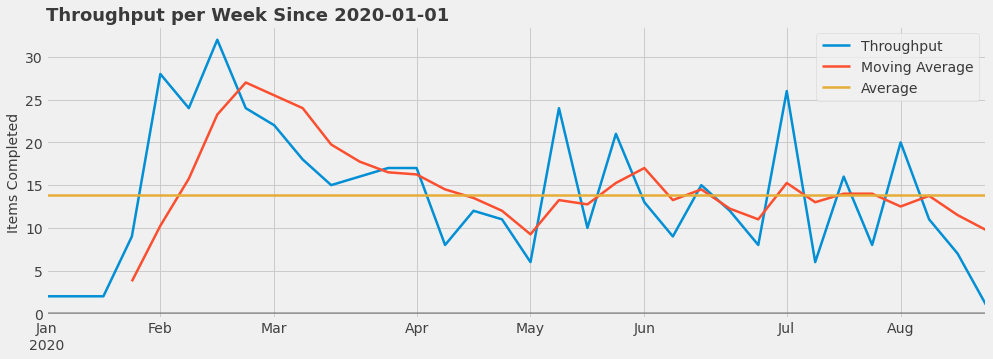

In [12]:
ax = throughput_per_week.plot(
    x='Date', y=['Throughput', 'Moving Average', 'Average'], linewidth=2.5, figsize=(15, 5), legend=True)
ax.set_title("Throughput per Week Since {}".format(FILTER_ISSUES_SINCE), loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'semibold'})

ax.set_xlabel('')
ax.set_ylabel('Items Completed')

ax.axhline(y=0, color=util.lightgrey, alpha=.5);

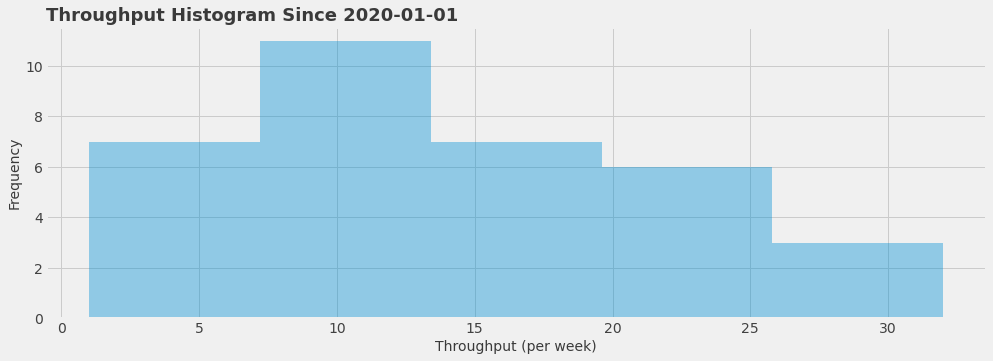

In [13]:
matplotlib.pyplot.figure(figsize=(15,5))

ax = seaborn.distplot(throughput_per_week['Throughput'], kde=False)
ax.set_title("Throughput Histogram Since {}".format(FILTER_ISSUES_SINCE), loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'semibold'})
ax.set_ylabel('Frequency')
_ = ax.set_xlabel('Throughput (per week)')

### Burndown

Let's check out the burnup/burndown:

In [14]:
FILTER_ISSUES_SINCE = '2020-01-01'

start = pandas.to_datetime(FILTER_ISSUES_SINCE)
end = pandas.to_datetime('today')

wip_data = []

while start <= end:
    
    wip_data.append({
        'date': start,
        'arrivals': (issue_data['new_day'] == start).sum(),
        'departures': (issue_data['complete_day'] == start).sum(),
    })
    
    start += pandas.Timedelta(days=1)

wip_data = pandas.DataFrame(wip_data, columns=['date', 'arrivals', 'departures'])

wip_data.tail(30)

,date,arrivals,departures
205,2020-07-24,2,3
206,2020-07-25,0,0
207,2020-07-26,0,0
208,2020-07-27,4,0
209,2020-07-28,9,11
210,2020-07-29,1,5
211,2020-07-30,3,2
212,2020-07-31,1,1
213,2020-08-01,0,0
214,2020-08-02,0,0


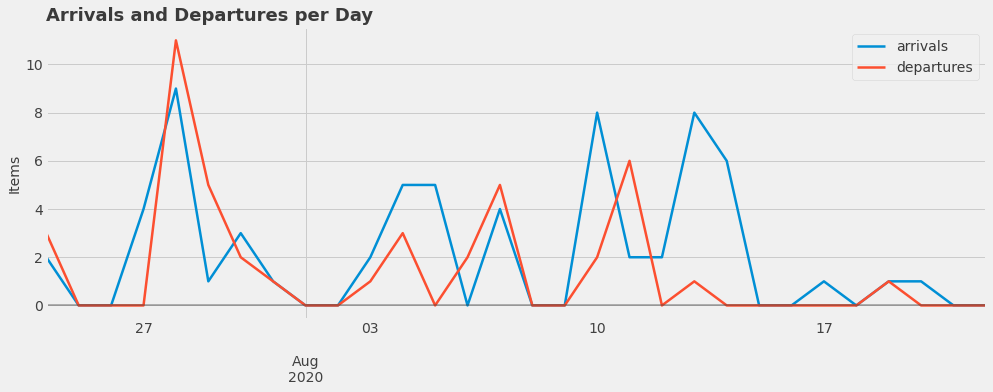

In [28]:
ax = wip_data.tail(30).plot(
    x='date', y=['arrivals', 'departures'], linewidth=2.5, figsize=(15, 5), legend=True)
ax.set_title("Arrivals and Departures per Day", loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'semibold'})

ax.set_xlabel('')
ax.set_ylabel('Items')

ax.axhline(y=0, color=util.lightgrey, alpha=.5);

---

## Estimation

Welcome to the main event. 

### Kaplan-Meier Surviability

We can also use our historical cycle time data and fit it into a Kaplan-Meier survivability curve.

This model will allow us to estimate the probability of a single issue having a cycle time longer than a particular value (i.e., surviving past a point in time):

In [16]:
from lifelines import KaplanMeierFitter

FILTER_ISSUES_SINCE = '2020-01-01'

survivability_data = issue_data.copy()
survivability_data = survivability_data.where(survivability_data['complete_day'] > pandas.to_datetime(FILTER_ISSUES_SINCE)).dropna()

durations = survivability_data['cycle_time_days']
event_observed = [1 if c else 0 for c in survivability_data['cycle_time_days']]

## create a kmf object as km
km = KaplanMeierFitter() ## instantiate the class to create an object

## Fit the data into the model
model = km.fit(durations, event_observed,label='Kaplan Meier Estimate')

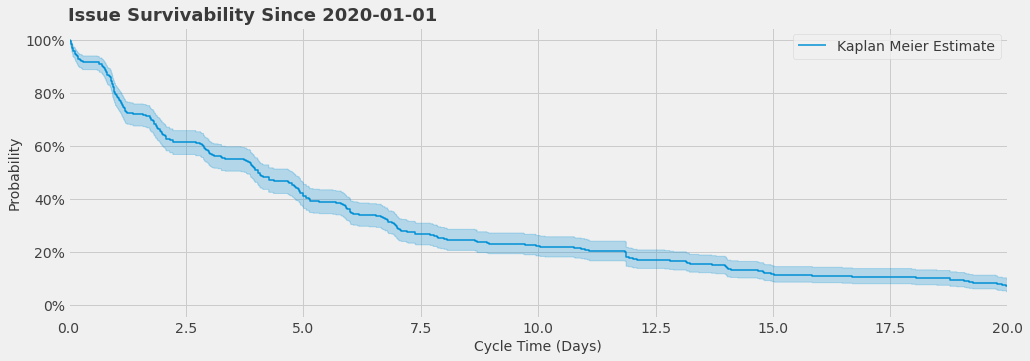

In [29]:
## Create an estimate
ax = km.plot(figsize=(15, 5))
ax.set_title('Issue Survivability Since {}'.format(FILTER_ISSUES_SINCE), loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'semibold'})

def format_func(value, tick_number):
    return '{}%'.format(int(value*100))
ax.set_xlim([0, 20])
ax.yaxis.set_major_formatter(matplotlib.pyplot.FuncFormatter(format_func))
ax.set_ylabel('Probability')
_ = ax.set_xlabel('Cycle Time (Days)')

*How do you read this graph?*

> The probability of an issue having a cycle time > 10 days (i.e., surviving past 10 days) is just over 20%.

### Monte Carlo Simulation

So, what if you want to have a prediction of many issues over time? We can use a Monte Carlo simulations based on our historical Kanban metrics. 

We can approach this estimation from two ways:

1. [WHEN]: By what date will N number of items be completed?
2. [HOW MANY]: How many items will be completed in the next N days?

#### [WHEN]: By what date will N number of items be completed?

The Monte Carlo simulation will use the historical distribution of throughput to estimate the future distribution of throughput.

With this simulation, we can compute how long it will take to complete N number of items if the historical distribution holds.

In [18]:
SIMULATION_ITEMS = 10 # N
SIMULATIONS = 10000
LAST_DAYS = 90
START_DATE = pandas.to_datetime('today')

In [32]:
def simulate_days(data, scope):
    days = 0
    total = 0
    while total <= scope:
        total += data.sample(n=1).iloc[0].Throughput
        days += 1
    completion_date = START_DATE + pandas.Timedelta(days, unit='d')
    return completion_date


dataset = throughput[['Throughput']].tail(LAST_DAYS).reset_index(drop=True)

samples = [simulate_days(dataset, SIMULATION_ITEMS)
           for i in range(SIMULATIONS)]

samples = pandas.DataFrame(samples, columns=['Date'])

distribution_when = samples.groupby(['Date']).size().reset_index(name='Frequency')

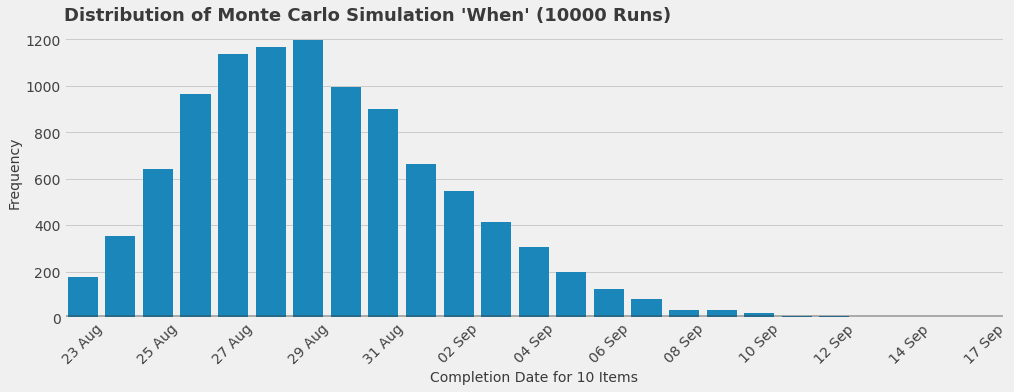

In [33]:
matplotlib.pyplot.figure(figsize=(15, 5))

ax = seaborn.barplot(x='Date', y='Frequency', data=distribution_when, color=util.barblue)
ax.set_title(f"Distribution of Monte Carlo Simulation 'When' ({SIMULATIONS} Runs)", loc='left',
             fontdict={'size': 18, 'weight': 'semibold'})
ax.set_xlabel(f"Completion Date for {SIMULATION_ITEMS} Items")
ax.set_ylabel('Frequency')
unique_dates = sorted(list(distribution_when['Date'].drop_duplicates()))
date_ticks = range(0, len(unique_dates), len(unique_dates)//10)
ax.set_xticks(date_ticks)
ax.set_xticklabels([unique_dates[i].strftime('%d %b')
                    for i in date_ticks], rotation=45)
ax.axhline(y=SIMULATIONS*0.001, color=util.darkgrey, alpha=.5);

Then, we can analyze the probability of completion based on this distribution.

In [34]:
distribution_when = distribution_when.sort_index(ascending=False)
distribution_when['Probability'] = 100 - 100 * \
    distribution_when.Frequency.cumsum()/distribution_when.Frequency.sum()

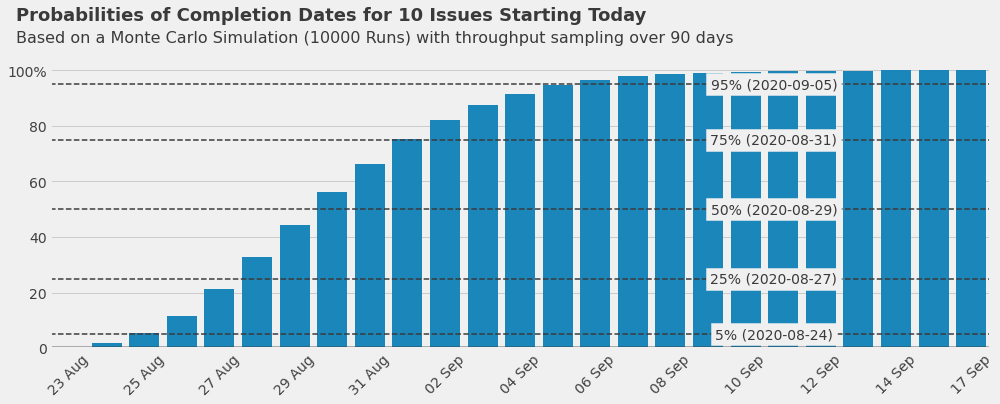

In [35]:
matplotlib.pyplot.figure(figsize=(15, 5))

ax = seaborn.barplot(x='Date', y='Probability', data=distribution_when, color=util.barblue)
ax.text(x=-1.4, y=118,
        s=f"Probabilities of Completion Dates for {SIMULATION_ITEMS} Issues Starting Today", fontsize=18, fontweight='semibold')
ax.text(x=-1.4, y=110,
        s=f"Based on a Monte Carlo Simulation ({SIMULATIONS} Runs) with throughput sampling over {LAST_DAYS} days", fontsize=16)

ax.set_ylabel('')
ax.set_xlabel('')
ax.axhline(y=0.5, color=util.darkgrey, alpha=.5)
ax.axhline(y=5, color=util.darkgrey, linestyle='--')
ax.axhline(y=25, color=util.darkgrey, linestyle='--')
ax.axhline(y=50, color=util.darkgrey, linestyle='--')
ax.axhline(y=75, color=util.darkgrey, linestyle='--')
ax.axhline(y=95, color=util.darkgrey, linestyle='--')

unique_dates = sorted(list(distribution_when['Date'].drop_duplicates()))
date_ticks = range(0, len(unique_dates), len(unique_dates)//10)

xpos = 0.75 * len(unique_dates)
ax.text(y=5, x=xpos, s=f"5% ({samples.Date.quantile(0.05).strftime('%Y-%m-%d')})",
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=25, x=xpos, s=f"25% ({samples.Date.quantile(0.25).strftime('%Y-%m-%d')})",
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=50, x=xpos, s=f"50% ({samples.Date.quantile(0.5).strftime('%Y-%m-%d')})",
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=75, x=xpos, s=f"75% ({samples.Date.quantile(0.75).strftime('%Y-%m-%d')})",
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=95, x=xpos, s=f"95% ({samples.Date.quantile(0.95).strftime('%Y-%m-%d')})",
        va='center', ha='center', backgroundcolor='#F0F0F0')

ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels(labels=['0', '20', '40', '60', '80', '100%'])

ax.set_xticks(date_ticks)
ax.set_xticklabels([unique_dates[i].strftime('%d %b')
                    for i in date_ticks], rotation=45);

#### How many items will be completed in the next N days?

The Monte Carlo simulation will use the historical distribution of throughput to estimate the future distribution of throughput.

With this simulation, we can compute how many items will be completed in the next N days if the historical distribution holds.

In [23]:
SIMULATION_DAYS = 10 # N
SIMULATIONS = 10000
LAST_DAYS = 90

In [36]:
dataset = throughput[['Throughput']].tail(LAST_DAYS).reset_index(drop=True)
samples = [dataset.sample(n=SIMULATION_DAYS, replace=True).sum(
).Throughput for i in range(SIMULATIONS)]
samples = pandas.DataFrame(samples, columns=['Items'])
distribution_how = samples.groupby(['Items']).size().reset_index(name='Frequency')

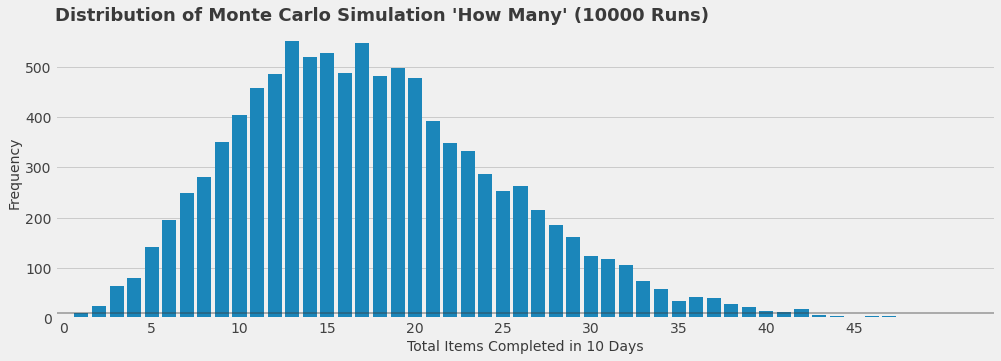

In [37]:
matplotlib.pyplot.figure(figsize=(15, 5))

ax = seaborn.barplot(x='Items', y='Frequency', data=distribution_how, color=util.barblue)
ax.set_title(f"Distribution of Monte Carlo Simulation 'How Many' ({SIMULATIONS} Runs)", loc='left',
             fontdict={'size': 18, 'weight': 'semibold'})
ax.set_xlabel(f"Total Items Completed in {SIMULATION_DAYS} Days")
ax.set_ylabel('Frequency')

ax.set_xticks(distribution_how['Items'][0::len(distribution_how['Items'])//10])

ax.axhline(y=SIMULATIONS*0.001, color=util.darkgrey, alpha=.5);

Then, we can analyze the probability of completion based on this distribution.

In [38]:
distribution_how = distribution_how.sort_index(ascending=False)
distribution_how['Probability'] = 100 * \
    distribution_how.Frequency.cumsum()/distribution_how.Frequency.sum()

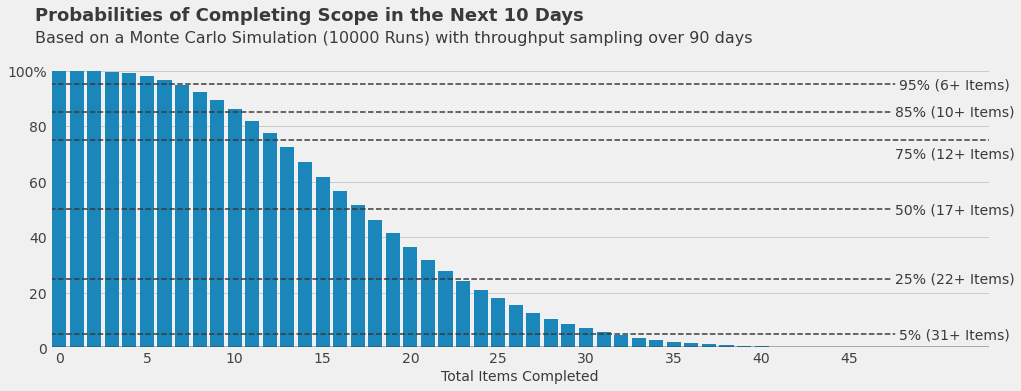

In [39]:
matplotlib.pyplot.figure(figsize=(15, 5))

ax = seaborn.barplot(x='Items', y='Probability', data=distribution_how, color=util.barblue)

ax.text(x=-1.4, y=118,
        s=f"Probabilities of Completing Scope in the Next {SIMULATION_DAYS} Days", fontsize=18, fontweight='semibold')
ax.text(x=-1.4, y=110,
        s=f"Based on a Monte Carlo Simulation ({SIMULATIONS} Runs) with throughput sampling over {LAST_DAYS} days", fontsize=16)
ax.set_ylabel('')
ax.set_xlabel('Total Items Completed')

ax.axhline(y=0.5, color=util.darkgrey, alpha=.5)
ax.axhline(y=5, color=util.darkgrey, linestyle='--')
ax.axhline(y=25, color=util.darkgrey, linestyle='--')
ax.axhline(y=50, color=util.darkgrey, linestyle='--')
ax.axhline(y=75, color=util.darkgrey, linestyle='--')
ax.axhline(y=85, color=util.darkgrey, linestyle='--')
ax.axhline(y=95, color=util.darkgrey, linestyle='--')

label_xpos = distribution_how['Items'].max()-2

ax.text(y=5, x=label_xpos, s=f'5%% (%d+ Items)' % samples.Items.quantile(0.95),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=25, x=label_xpos, s=f'25%% (%d+ Items)' % samples.Items.quantile(0.75),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=50, x=label_xpos, s=f'50%% (%d+ Items)' % samples.Items.quantile(0.5),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=70, x=label_xpos, s=f'75%% (%d+ Items)' % samples.Items.quantile(0.25),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=85, x=label_xpos, s=f'85%% (%d+ Items)' % samples.Items.quantile(0.15),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=95, x=label_xpos, s=f'95%% (%d+ Items)' % samples.Items.quantile(0.05),
        va='center', ha='center', backgroundcolor='#F0F0F0')

ax.set_xticks(distribution_how['Items'][0::len(distribution_how['Items'])//10])

ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels(labels=['0', '20', '40', '60', '80', '100%']);